In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker, build_random_parity_map
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Load comb circuits

In [2]:
def extract_sub_matrix(matrix, index_list):
    new_matrix = Mat2(np.zeros([len(index_list), matrix.cols()], dtype=int))
    for row in range(new_matrix.rows()):
        for col in range(new_matrix.cols()):
            new_matrix.data[row][col] = matrix.data[index_list[row]][col]
    return new_matrix
def insert_sub_matrix(matrix, sub_matrix, index_list):
    for row in range(sub_matrix.rows()):
        for col in range(sub_matrix.cols()):
            matrix.data[index_list[row]][col] = sub_matrix.data[row][col]
    return matrix
def remove_rowcol(matrix, index):
    matrix.data = np.delete(matrix.data, index, 0)
    matrix.data = np.delete(matrix.data, index, 1)
    print(matrix)

In [3]:
def combrowcol(circuit, arch, *args, **kwargs):
    circ = circuit.copy()
    OUTER_DISPLAY and display(zx.draw(circ))
    decomposition = CombDecomposition.from_circuit(circ)
    comb = decomposition.comb
    OUTER_DISPLAY and display(zx.draw(comb))
    new_comb = CNOTComb(comb.qubits, comb.holes.copy(), comb.new_to_old_qubit_mappings)
    # Create a copy of the parity matrix of the comb to perform gaussian elimination on
    matrix = comb.matrix.copy()

    DEBUG and print(comb.matrix)
    
    # Determine which qubits depend on the availability of other qubits
    qubit_dependence = dict([(i, set()) for i in range(comb.qubits)])
    for gate in comb.gates:
        # Example, gate = CNOT(2,3)
        # Qubit 3 now depends on qubit 2 being available
        # All the qubits that depended on 2 being available now depend on 3 being available
        # Qubit 2 now depends on qubit 3 being available
        # All the qubits that depended on 3 being available now depend on 2 being available
        qubit_dependence[gate.control].add(gate.target)
        qubit_dependence[gate.control] = qubit_dependence[gate.control].union(qubit_dependence[gate.target])
        qubit_dependence[gate.target].add(gate.control)
        qubit_dependence[gate.target] = qubit_dependence[gate.target].union(qubit_dependence[gate.control])
    
    # Iterate over the gates in the comb and log with qubits are connected via CNOTs
    qubit_connections = dict([(i,[]) for i in range(comb.qubits)])
    for gate in comb.gates:
        # What we want to be doing here is not just adding connected control to target
        # but connecting control to all the qubits connected to target
        for q in qubit_connections[gate.target]:
            if gate.control not in qubit_connections[q] and gate.control != q:
                qubit_connections[q].append(gate.control)
        for q in qubit_connections[gate.control]:
            if gate.target not in qubit_connections[q] and gate.target != q:
                qubit_connections[q].append(gate.target)
        
        if gate.control not in qubit_connections[gate.target]:
            qubit_connections[gate.target].append(gate.control)
        if gate.target not in qubit_connections[gate.control]:
            qubit_connections[gate.control].append(gate.target)
        #print(f"Gate : {gate}")
        #print(f"Qubit Connections : {qubit_connections}")
        #qubit_connections[gate.target]  = list(set(qubit_connections[gate.target]).union(set(qubit_connections[gate.control])))
        #qubit_connections[gate.control] = list(set(qubit_connections[gate.target]).union(set(qubit_connections[gate.control])))
    
    #print(comb.matrix)
    #print(f"Gates : {comb.gates}")
    
    # Find initial qubits for the sub matrix
    qubits_in_matrix = []
    old_to_new_qubits = dict([(i,[]) for i in range(circ.qubits)])
    for virtual_qubit in comb.new_to_old_qubit_mappings.keys():
        old_to_new_qubits[comb.new_to_old_qubit_mappings[virtual_qubit]].append(virtual_qubit)
    for logical_qubit in old_to_new_qubits.keys():
        if len(old_to_new_qubits[logical_qubit]) == 0:
            qubits_in_matrix.append(logical_qubit)
        else:
            qubits_in_matrix.append(max(old_to_new_qubits[logical_qubit]))    

    DEBUG and print(qubits_in_matrix)


    # These are the qubits still accessible on the architecture
    # This doesn't include virtual qubits
    rows_to_eliminate = list(range(circ.qubits))
    cols_to_eliminate = list(range(comb.qubits))
    while 0 < len(cols_to_eliminate):        

        # Generate sub matrix
        sub_matrix = extract_sub_matrix(matrix, qubits_in_matrix)
        sub_circuit = CNOT_tracker(circ.qubits, parities_as_columns=False)
        col_to_eliminate = next_elimination(qubit_dependence, qubits_in_matrix, arch, rows_to_eliminate)
        DEBUG and print(comb.holes)
        DEBUG and print(comb.new_to_old_qubit_mappings)

        #print(f"Qubit Connections : {qubit_connections}")
        #print(f"Col to eliminate : {col_to_eliminate}")
        
        # Take account of mapping from virtual to logical qubits
        if col_to_eliminate in comb.new_to_old_qubit_mappings:
            row_to_eliminate = comb.new_to_old_qubit_mappings[col_to_eliminate]
        else:
            row_to_eliminate = col_to_eliminate

        DEBUG and print(f"Qubit to eliminate {col_to_eliminate} ({row_to_eliminate})")

        # Remove current rowcol from matrix
        rowcol_iteration(sub_matrix, # need to generate correct sub matrix
                         arch,
                         row_to_eliminate, # rowcol needs to 'see' the virtual qubit as the original
                         col_to_eliminate,
                         rows_to_eliminate, # need to generate list of qubits currently accessible
                         cols_to_eliminate,
                         circuit=sub_circuit)
        DEBUG and print(sub_circuit.gates)

        # Convert the gates of the sub matrix using the mapping
        for gate in sub_circuit.gates[::-1]:
            gate.control = qubits_in_matrix[gate.control]
            gate.target = qubits_in_matrix[gate.target]
            # Add gates from sub circuit to comb circuit
            new_comb.gates.insert(0, gate)
        # Insert submatrix back into larger matrix
        insert_sub_matrix(matrix, sub_matrix, qubits_in_matrix)    

        DEBUG and print(new_comb.gates)


        # If the qubit just removed maps to another qubit via a hole
        # replace that qubit with the new qubit in the qubits_in_matrix list
        qubit_found = False
        qubit_loc = 0
        while not qubit_found:
            qubit = qubits_in_matrix[qubit_loc]
            if qubit == col_to_eliminate:
                qubit_found = True
                # Remove virtual qubit
                cols_to_eliminate.remove(col_to_eliminate)
                # Check if there are anymore virtual qubits that could be assigned to this logical one
                if qubit in comb.holes.inverse.keys():
                    qubits_in_matrix[qubit_loc] = comb.holes.inverse.pop(qubit)
                else:
                    # If no more virtual qubits can be assigned we remove it from being considered
                    # available in the architecture
                    if qubit in comb.new_to_old_qubit_mappings:
                        rows_to_eliminate.remove(comb.new_to_old_qubit_mappings[qubit])
                    else:
                        rows_to_eliminate.remove(qubit)
            qubit_loc += 1
        # Remove the qubit that has just been eliminated from the connections
        qubit_connections[col_to_eliminate] = []
        for qubit in qubit_connections:
            if col_to_eliminate in qubit_connections[qubit]:
                qubit_connections[qubit].remove(col_to_eliminate)

        # Remove the qubit that has just been eliminated from the connections
        qubit_dependence.pop(col_to_eliminate)
        for qubit in qubit_dependence:
            if col_to_eliminate in qubit_dependence[qubit]:
                qubit_dependence[qubit].remove(col_to_eliminate)
        
        INNTER_DISPLAY and display(zx.draw(new_comb))
    
    #print(f"Circuit Gates : {circ.gates}")
    #print(f"Comb Gates : {new_comb.gates}")
    #print(f"Holes : {decomposition.hole_plugs}")
    decomposition.comb = new_comb
    new_circuit = CombDecomposition.to_circuit(decomposition)
    OUTER_DISPLAY and display(zx.draw(new_circuit))
    return new_circuit, (matrix.data == np.eye(comb.qubits, dtype=int)).all()

In [4]:
def elimination_order(comb, qubits):
    #return [3,2,0,1]
    pass

def next_elimination(qubit_dependence, qubits_in_matrix, arch, rows_to_eliminate):
    Prn = False
    
    # Use the qubit_dependence
    possible_eliminations = set(qubit_dependence.keys())
    # It's easier to find all the qubits that can't be eliminated by seeing all the qubits
    # that depend on currently unavailable qubits
    
    # I need all the elements in possible_eliminations that aren't in qubits_in_matrix
    unavailable_qubits = (possible_eliminations ^ set(qubits_in_matrix)) & possible_eliminations
    # Generate a set of all the qubits that depend on currently unavailable qubits
    impossible_eliminations = unavailable_qubits.copy()
    for q in unavailable_qubits:
        impossible_eliminations = impossible_eliminations.union(qubit_dependence[q])
    # possible_eliminations now becomes all the qubits not in impossible eliminations
    possible_eliminations = possible_eliminations ^ impossible_eliminations
    # Find non-cutting vertices
    non_cutting_vertices = arch.non_cutting_vertices(rows_to_eliminate)
    non_cutting_qubits = [arch.vertex2qubit(v) for v in non_cutting_vertices]
    #print(f"Possible Eliminations : {possible_eliminations}")
    #print(f"Non Cutting Qubits : {non_cutting_qubits}")
    
    eliminate = [elim for elim in possible_eliminations if (elim >= len(qubits_in_matrix) or elim in non_cutting_qubits)].pop()
    #eliminate = possible_eliminations.pop()
    if Prn:
        print(f"Qubit Dependence : {qubit_dependence}")
        print(f"Qubits in matrix : {qubits_in_matrix}")
        print(f"Impossible Eliminations : {impossible_eliminations}")
        print(f"Eliminate : {eliminate}")
    return eliminate
    

def next_elimination(qubit_connections, qubits_in_matrix, cols_to_eliminate):
    Pnt = False
    qubit_found = False
    qubit_index = 0
    qubit_to_eliminate = None
    
    Pnt and print(f"Qubit Connections : {qubit_connections}")
    Pnt and print(f"Qubit in Matrix : {qubits_in_matrix}")
    
    available_qubits = list(set(qubits_in_matrix) & set(cols_to_eliminate))
    #print(f"Available Qubits : {available_qubits}")
    
    while not qubit_found and qubit_index < len(available_qubits):
        # If if one of he currently accessible qubits is only connected to qubits that are also
        # currently accessible
        
        Pnt and print(f"Considering Qubit : {available_qubits[qubit_index]}")
        Pnt and print(f"Length : {len(qubit_connections[available_qubits[qubit_index]])}")
        Pnt and print(set(qubit_connections[available_qubits[qubit_index]]).issubset(set(available_qubits)))
        
        if set(qubit_connections[available_qubits[qubit_index]]).issubset(set(available_qubits)):
            qubit_found = True
            qubit_to_eliminate = available_qubits[qubit_index]
        qubit_index += 1
    Pnt and print(f"Qubit to Eliminate : {qubit_to_eliminate}")
    return qubit_to_eliminate

def next_elimination(sub_matrix, qubits_in_matrix, cols_to_eliminate):
    qubit_found = False
    rows = range(sub_matrix.data.shape[0])
    cols = range(sub_matrix.data.shape[1])
    index = 0
    #print(f"Sub Matrix : \n {sub_matrix}")
    #print(f"Qubits in matrix : \n {qubits_in_matrix}")
    M = sub_matrix.copy()
    M.gauss(full_reduce=True)
    possible_eliminations = []
    
    for index in range(len(qubits_in_matrix)):
        col = qubits_in_matrix[rows[index]]
        
        if col in cols_to_eliminate:
            # Get all the rows that have a 1 in the desired column
            ones = [r for r in rows if M.data[r][col] == 1]
            # Check that there is only one row with a 1 in it
            if len(ones) == 1:
                row = ones.pop()
                # Check that the row only has one one in it
                if sum([M.data[row][c] for c in cols]) == 1:
                    possible_eliminations.append(col)                
    #print(f"M : \n{M}")
    #print(f"Possible Eliminations : {possible_eliminations}")
    return possible_eliminations[0]
        

In [7]:
comb_circuit_folder = "../circuits/combs-ZX/"

n_qubits = [4]
n_cnots = [10]
n_non_cnots = [4]
loaded_circuits = {}
for qubits in n_qubits:
    for cnots in n_cnots:
        for non_cnots in n_non_cnots:
            circuit_properties = {"Qubits"    : qubits,
                                  "CNOTs"     : cnots,
                                  "Non-CNOTs" : non_cnots}
            path = os.path.join(comb_circuit_folder,
                                str(circuit_properties["Qubits"])+"qubits", 
                                str(circuit_properties["CNOTs"])+"cnots", 
                                str(circuit_properties["Non-CNOTs"])+"non-cnots")
            loaded_circuits[f"({qubits},{cnots},{non_cnots})"] = []
            if os.path.exists(path):
                for file_name in os.listdir(path):
                    loaded_circuits[f"({qubits},{cnots},{non_cnots})"].append(circuit.Circuit.from_qasm_file(os.path.join(path, file_name)))
            else:
                print("Directory Does Not Exist")

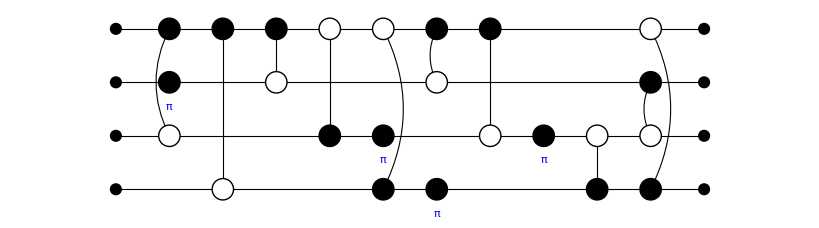

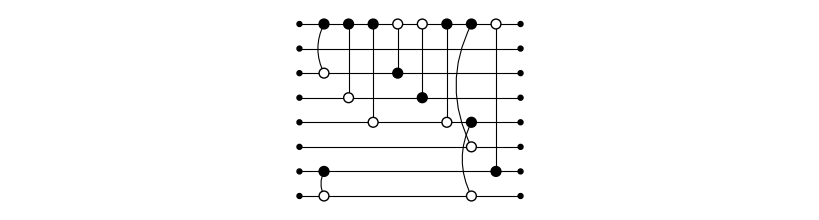

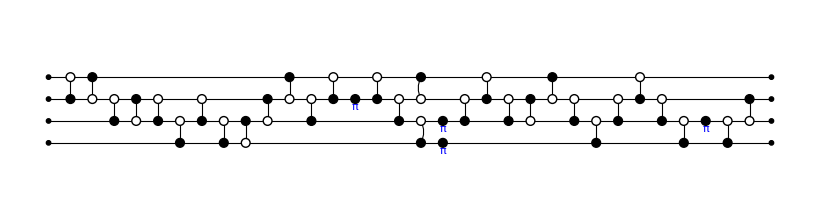

Qubits : 4, CNOTs : 10, Non-CNOTs : 4 -> 1


In [11]:
from IPython.display import display, Markdown

DEBUG = False
OUTER_DISPLAY = True
INNTER_DISPLAY = False

for qubits in n_qubits:
    for cnots in n_cnots:
        for non_cnots in n_non_cnots:
            arch = architecture.create_architecture(architecture.LINE, n_qubits=qubits)
            equal = 0
            for INDEX in [10]: #range(100):
                if False:
                    # Get circuit
                    circ = loaded_circuits[f"({qubits},{cnots},{non_cnots})"][INDEX]
                    # Draw circuit
                    OUTER_DISPLAY and display(zx.draw(circ))
                    # Decompose circuit into comb and holes
                    decomposition = CombDecomposition.from_circuit(circ.copy())
                    comb = decomposition.comb
                    # Draw comb
                    OUTER_DISPLAY and display(zx.draw(comb))
                    # Recompose circuit from comb and holes
                    new_circuit = CombDecomposition.to_circuit(decomposition)
                    # Display recomposed circuit
                    OUTER_DISPLAY and display(zx.draw(new_circuit))
                    # Check whether the recomposed circuit is the same as the original
                    equality = new_circuit.verify_equality(circ)
                    equal += equality
                else:
                    circ = loaded_circuits[f"({qubits},{cnots},{non_cnots})"][INDEX]
                    new_circ, Id = combrowcol(circ, arch)
                    equality = new_circ.verify_equality(circ)
                    equal += equality
                    #print(f"INDEX: {INDEX} {equality}")
                    #equal += Id
                    #print(f"Reduced to identity : {INDEX} {Id}")
            print(f"Qubits : {qubits}, CNOTs : {cnots}, Non-CNOTs : {non_cnots} -> {equal}")